# <span style="color:#484848;"> HRV Seizure Detection </span>

### <span style="color:#484848;"> Classification Pipeline </span>

### <span style="color:#00aba1;"> Keywords </span>
`machine learning`, `seizure detection`, `hrv`

### <span style="color:#00aba1;"> Notebook Info </span>

**Author(s):** Mariana Abreu

**Date of creation:** 10/10/2022

**Last update:** 10/10/2022

**Last revision:** 10/10/2022

### <span style="color:#00aba1;"> Description </span>
The purpose of this notebook is to follow all the steps from an epileptic dataset to a classification decision.

### <span style="color:#00aba1;"> Requirements </span>

* Basic knowledge of Python

* Access to database (OneDrive)

# <span style="color:#00aba1;"> 1. From Continuous Features to Discrete Features </span>

## <span style="color:#484848;"> 1.1. Function level2_features </span>

In the pipeline_processing notebook we reached the hrv features cleaned and each segment has one hour duration.
We could find a model that learns the continuous temporal evolution of hrv features, or we could translate the behaviour into discrete features:

* minmax - returns the peak-to-peak amplitude
* skewness - returns the left or right deviation
* trend-ratio - is a made-up measure with the purpose of seeing the last half median over the first half median
* trend-diff - same as previous but it is the difference instead of the ratio
* deriv - first derivative of the peak-to-peak (y2-y1)/(x2-x1) where x2 > x1



In [1]:
import os
import pandas as pd
from src import level2_features

save_dir = 'C:\\Users\\Mariana\\OneDrive - Universidade de Lisboa\\G5\\data'
patient = '413'
type = 'baseline'
features_data = pd.read_parquet(os.path.join(dir, 'features_p' + patient + '_'+ type +'.parquet'))
list_features = [feat for feat in features_data.columns if feat not in ['t0', 't1', 'label', 'time2end']]
features_data.head()

TypeError: expected str, bytes or os.PathLike object, not builtin_function_or_method

In [28]:
features_data = pd.read_parquet(os.path.join(dir, 'level2_features_p' + patient + '_'+ type +'.parquet'))
#features_data = pd.read_parquet(os.path.join(dir, 'clean_features_p' + patient + '_'+ type +'.parquet'))
features_data['label']

0       baseline0
1       baseline0
2       baseline0
3       baseline0
4       baseline0
          ...    
2335    baseline9
2336    baseline9
2337    baseline9
2338    baseline9
2339    baseline9
Name: label, Length: 2340, dtype: object

In [7]:
features_data = pd.read_parquet(os.path.join(save_dir, 'features_p' + patient + '_'+ type +'.parquet'))
list_features = [feat for feat in features_data.columns if feat not in ['t0', 't1', 'label', 'time2end']]
list_features

['hr_min',
 'hr_max',
 'hr_minmax',
 'hr_avg',
 'hr_med',
 'rr_mean',
 'rmssd',
 'nn50',
 'pnn50',
 'sdnn',
 'hti',
 'tinn',
 'ulf_pwr',
 'ulf_peak',
 'ulf_rpwr',
 'vlf_pwr',
 'vlf_peak',
 'vlf_rpwr',
 'lf_pwr',
 'lf_peak',
 'lf_rpwr',
 'hf_pwr',
 'hf_peak',
 'hf_rpwr',
 'vhf_pwr',
 'vhf_peak',
 'vhf_rpwr',
 'lf_hf',
 's',
 'sd1',
 'sd2',
 'sd12',
 'sd21']

## <span style="color:#484848;"> 1.2. Open the RRi file extracted </span>

In [4]:
import os
import pandas as pd
patient = 'p413'
save_dir = 'C:\\Users\\Mariana\\OneDrive - Universidade de Lisboa\\G5\\data'
patient_data = pd.read_parquet(os.path.join(save_dir, patient + '_rri.parquet'))
patient_data.head()

,rri,index,fileid
0,492.18750,2020-09-21 12:26:33.515625559,000
1,476.56250,2020-09-21 12:26:33.992188576,000
2,234.37500,2020-09-21 12:26:34.226563830,000
3,304.68750,2020-09-21 12:26:34.531251661,000
4,472.65625,2020-09-21 12:26:35.003908424,000


## <span style="color:#484848;"> 1.3. Plot RRi near a seizure </span>

1) Get the seizures times for that patient, which were saved in the csv file "seizure_label_patient". Select one of these times in the variable **seizure_time**
2) Select the data between 2 minutes before and 2 minutes after one seizure onset in **cropped_data**.
3) Plot cropped data with a vertical line in the location of the seizure onset

To understand the effect of each part of the code (especially in the plot) you could comment line by line or change parameters (such as what is inside clips '').

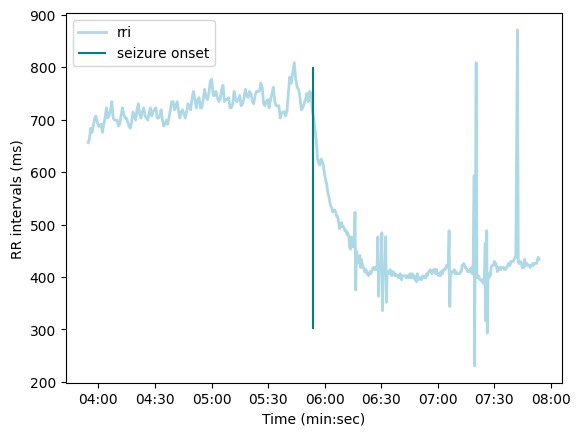

In [7]:
import datetime
import os
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
colors = {'lightblue': '#A9D1ED', 'lightorange': '#F8CBAD',  'darkblue': '#003399', 'onset': '#843C0C', 'teal':'teal', }
save_dir = 'C:\\Users\\Mariana\\OneDrive - Universidade de Lisboa\\G5\\data'
# 1)
seizures = pd.read_csv(os.path.join(save_dir, 'seizure_label_' + patient), index_col=0)
times = pd.to_datetime(seizures['Date'])
seizure_time = times.loc[0]
# 2)
cropped_data = patient_data.loc[patient_data['index'].between(times.iloc[0] - datetime.timedelta(seconds=120), times.iloc[0] + datetime.timedelta(seconds=120))]
# 3)
fig, ax = plt.subplots()
plt.plot(cropped_data['index'], cropped_data['rri'], label='rri', color='lightblue', linewidth='2')
plt.vlines(times.iloc[0], 300, 800, color='teal', label='seizure onset')
plt.ylabel('RR intervals (ms)')
plt.xlabel('Time (min:sec)')
ax.xaxis.set_major_formatter(DateFormatter('%M:%S'))
plt.savefig('z3_rri_signal')
plt.legend()
plt.show()

# <span style="color:#00aba1;"> 2. Extract Features </span>

The process of feature extraction could be done in many different ways: for the entire data, for shorter segments of the data, etc.
In this case, we start by dividing the data into baseline or seizure. This is useful because baseline can take a great time to run (it contains many samples) and this division allows to have a fast calculation if only seizure intervals are of interest.

The size of each segment for which features are extracted is defined as **window** and it is in seconds. The true overlap between consecutive windows is defined by **overlap**, which is also in seconds, however in this case, **overlap** variable corresponds to the jump given between consecutive windows.

Hence true overlap = **window - overlap**

## <span style="color:#484848;"> 2.1. Patient Loop </span>

A loop is created to repeat the process of feature extraction for all patients desired. This loop contains:

1) Get seizures from "seizure_label_patient"
2) Get RRi signal from "patient_rri.parquet"
3) Convert RRi dates (which could be defined in string) to real dates (datetime objects)
4) Choose window and overlap parameters
5) call function **get_features_good_intervals** with **type** = 'baseline' or 'seizure'

In [1]:
import os
import time
import pandas as pd
from src.extract_features import get_features_good_intervals

In [2]:
save_dir = 'C:\\Users\\Mariana\\OneDrive - Universidade de Lisboa\\G5\\data'

for patient_num in ['352']:
    print('Processing features for patient ', patient_num)
    time_start = time.time()

    patient = 'p' + patient_num
    old_patient = 'PAT_' + patient[1:]
    seizures = pd.read_csv(os.path.join(save_dir, 'seizure_label_'+patient), index_col=0)

    # get seizure times
    seizure_dates = pd.to_datetime(seizures['Date'], dayfirst=True)

    # get rr intervals
    rri_signal = pd.read_parquet(os.path.join(save_dir, patient+'_rri.parquet'))
    # pass string of times to datetime
    rri_signal['dates'] = pd.to_datetime(rri_signal['index'])

    # window in seconds
    window = 300
    overlap = 30

    get_features_good_intervals(rri_signal, type='seizures', patient=patient, seizure_dates=seizure_dates, overlap=overlap, window=window, save_dir = save_dir)

    print(f'Time to process ... {time.time()-time_start}')

Processing features for patient  352
Currently on segment: 0/6938

AttributeError: module 'biosppy.signals.tools' has no attribute 'detrend_smoothness_priors'

## <span style="color:#484848;"> 2.2. Functions in Feature Extraction </span>

The script extract features is divided in 4 functions: *get_features_good_intervals*, *get_all_feats*, *get_seizures_df*, *get_baselines_df*

*get_seizures_df* is an auxiliary function to retrieve all rri_signals that respect the seizure boundaries: 1 hour prior the onset and 5 minutes after the onset
*get_baseline_df* is an auxiliary function to retrieve all rri_signals outside the seizure boundaries: everything but 2 hours prior to the onset and 1 hour after the onset

*get_features_good_intervals* is responsible to:
 1) call *get_seizures_df* or *get_baseline_df* according to **type**
 2) loop iteratively over all rri_signals using time spaced with the defined **overlap**.
 3) Inside the loop: crop the segment from rri_signal using the **time** of each loop as the initial time, and the **window** size to get the final time
 4) If the cropped segment has less than 70% of the size defined in **window**, it is rejected and the loop jumps to the next **time**
 5) If the cropped segment is accepted, the function *get_all_feats* is called to extract features from it.
 6) The features are saved in a new DataFrame **feats_df**

## <span style="color:#484848;"> 2.2. Features Extracted </span>

The features extracted correspond to features from temporal, frequency and nonlinear domain of the HRV.
The file "features_patient_seizure.parquet" contains the table with all features extracted for one patient, only from seizure segments.

In the next cell, we can open one feature file and see its details

In [4]:
import os
import pandas as pd
dir = 'C:\\Users\\Mariana\\OneDrive - Universidade de Lisboa\\G5\\data'
patient = 'p413'
features_data = pd.read_parquet(os.path.join(dir, 'features_' + patient + '_seizure.parquet'))

features_data.head()

,hr_min,hr_max,hr_minmax,hr_avg,hr_med,rr_mean,rmssd,nn50,pnn50,sdnn,...,vhf_rpwr,lf_hf,s,sd1,sd2,sd12,sd21,t0,t1,label
0,50.360656,307.200000,256.839344,88.336446,85.810056,692.491319,80.264858,15.0,3.480278,61.889566,...,0.294233,0.674679,11903.768896,56.755823,66.761208,0.850132,1.176288,2020-09-22 20:05:54.314896154,2020-09-22 20:10:54.314896154,seizure0
1,50.360656,301.176471,250.815815,87.971874,86.292135,692.294446,74.620119,12.0,2.790698,56.106505,...,0.353951,0.180202,9843.374574,52.764389,59.381782,0.888562,1.125414,2020-09-22 20:06:24.314896154,2020-09-22 20:11:24.314896154,seizure1
2,50.360656,301.176471,250.815815,88.124172,86.292135,691.451566,78.491847,15.0,3.488372,57.806120,...,0.293247,0.271221,10483.859969,55.502114,60.125931,0.923098,1.083309,2020-09-22 20:06:54.314896154,2020-09-22 20:11:54.314896154,seizure2
3,50.360656,301.176471,250.815815,88.005920,86.292135,692.360102,78.573114,15.0,3.496503,57.702068,...,0.213763,0.541433,10452.777901,55.559553,59.885697,0.927760,1.077865,2020-09-22 20:07:24.314896154,2020-09-22 20:12:24.314896154,seizure3
4,50.360656,301.176471,250.815815,87.753598,86.779661,692.430394,74.407895,12.0,2.790698,52.475411,...,0.210890,0.422823,8670.852417,52.614327,52.457538,1.002989,0.997020,2020-09-22 20:07:54.314896154,2020-09-22 20:12:54.314896154,seizure4


One seizure will have multiple segments, from 1 hour until 5 minutes after the seizure. to check a feature near a seizure onset, let's repeat the procedure done for the rri signal plot:
1) Get seizure onset time
2) Crop feature data around seizure onset and choose feature
3) Plot the selected feature

> 💡 **EXPLORE:** Change the values inside timedelta and see the visual effect it takes on temporal evolution

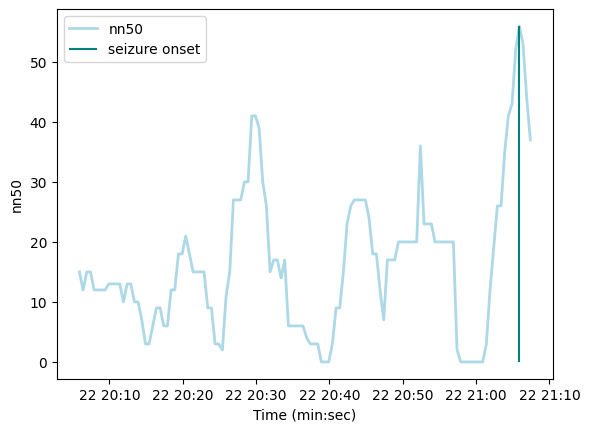

In [7]:
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

save_dir = 'C:\\Users\\Mariana\\OneDrive - Universidade de Lisboa\\G5\\data'
# 1)
seizures = pd.read_csv(os.path.join(save_dir, 'seizure_label_' + patient), index_col=0)
times = pd.to_datetime(seizures['Date'])
seizure_time = times.loc[0]
# 2)
feature = 'nn50'
cropped_data = features_data.loc[features_data['t0'].between(times.iloc[0] - datetime.timedelta(hours=1), times.iloc[0] + datetime.timedelta(seconds=120))]
# 3)
plt.plot(cropped_data['t0'], cropped_data[feature], label=feature, color='lightblue', linewidth=2)
plt.vlines(times.iloc[0], cropped_data[feature].min(), cropped_data[feature].max(), color='teal', label='seizure onset')
plt.ylabel(feature)
plt.xlabel('Time (min:sec)')
plt.savefig('C:\\Users\\Mariana\\Documents\\')
#ax[0].xaxis.set_major_formatter(DateFormatter('%M:%S'))
plt.legend()
plt.show()

# <span style="color:#00aba1;"> 3. Clean Features </span>

Features can present very different amplitudes and sharp edges. Besides, some intervals could be missing. In order to have a smoother, more comparable feature time serie, it suffers a standarisation, interpolation and smoothing.

In [2]:
from src import clean_features
import pandas as pd
import os
save_dir = 'C:\\Users\\Mariana\\OneDrive - Universidade de Lisboa\\G5\\data'
patient = 'p413'

clean_features.clean_features(patient, save_dir, type='seizure')
clean_data = pd.read_parquet(os.path.join(save_dir, 'clean_features_' + patient + '_seizure.parquet'))
clean_data.head()

p413 has 8 seizure segments


,hr_min,hr_max,hr_minmax,hr_avg,hr_med,rr_mean,rmssd,nn50,pnn50,sdnn,...,vhf_rpwr,lf_hf,s,sd1,sd2,sd12,sd21,label,time2end,t0
index,,,,,,,,,,,,,,,,,,,,,
0,-1.495249,-0.397609,-0.394484,-0.431621,-0.123075,0.077421,0.751724,-0.190751,-0.186431,0.342557,...,1.165481,-0.467218,0.315165,0.751734,0.076751,1.254004,-0.957188,seizure0,-3737.0,2020-09-22 20:06:07.314896154
1,-1.359972,-0.398055,-0.395221,-0.436856,-0.118973,0.078312,0.660680,-0.206835,-0.203160,0.269279,...,1.096781,-0.461366,0.236193,0.660689,0.018395,1.186804,-0.915843,seizure0,-3700.0,2020-09-22 20:06:44.314896154
2,-1.150934,-0.398880,-0.396495,-0.446285,-0.114620,0.082637,0.519082,-0.230706,-0.227610,0.160768,...,0.984277,-0.446281,0.116426,0.519091,-0.064293,1.070409,-0.840213,seizure0,-3663.0,2020-09-22 20:07:21.314896154
3,-0.904888,-0.400185,-0.398328,-0.459341,-0.113291,0.092239,0.350076,-0.256181,-0.253059,0.043465,...,0.835055,-0.422134,-0.019586,0.350083,-0.144981,0.905339,-0.724519,seizure0,-3626.0,2020-09-22 20:07:58.314896154
4,-0.649846,-0.401952,-0.400643,-0.474983,-0.117282,0.107621,0.173231,-0.278223,-0.274232,-0.063048,...,0.654805,-0.394033,-0.152090,0.173238,-0.205392,0.697339,-0.569722,seizure0,-3589.0,2020-09-22 20:08:35.314896154


> 💡 **EXPLORE:** Change feature (using the names of the columns of clean_data)

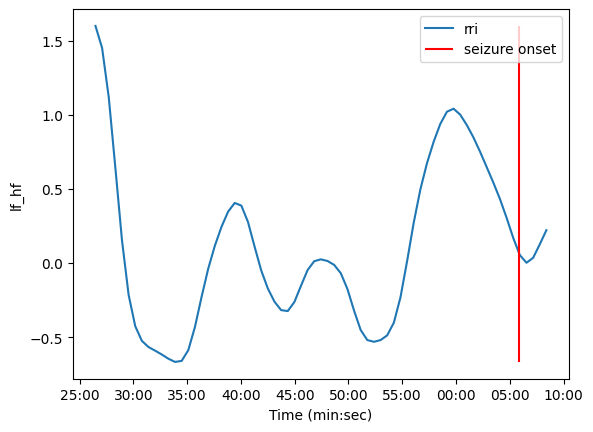

In [3]:
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

save_dir = 'C:\\Users\\Mariana\\OneDrive - Universidade de Lisboa\\G5\\data'
# 1)
seizures = pd.read_csv(os.path.join(save_dir, 'seizure_label_' + patient), index_col=0)
times = pd.to_datetime(seizures['Date'])
seizure_time = times.loc[0]
# 2)
feature = 'nn50'
cropped_data = clean_data.loc[clean_data['t0'].between(times.iloc[0] - datetime.timedelta(minutes=60), times.iloc[0] + datetime.timedelta(seconds=300))]
# 3)
fig, ax = plt.subplots()
plt.plot(cropped_data['t0'], cropped_data[feature], label='rri')
plt.vlines(times.iloc[0], cropped_data[feature].min(), cropped_data[feature].max(), color='red', label='seizure onset')
plt.ylabel(feature)
plt.xlabel('Time (min:sec)')
ax.xaxis.set_major_formatter(DateFormatter('%M:%S'))
plt.legend()
plt.show()